In [1]:
using Distributions
using HypothesisTests
using Random
using StatsBase
using StatsPlots
default(fmt=:png,
    titlefontsize=10, tickfontsize=6, guidefontsize=8, legendfontsize=8)

safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    phat_brunner_munzel(X, Y)

まず以下のようにおく:

```math
\begin{aligned}
&
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j]
\end{aligned}
```

この函数は次の $\hat{p}$ を返す:

```math
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j).
```
"""
phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

@doc raw"""
    statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^x - \bar{H}^y + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
```
"""
function statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        Hx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        Hy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(Hy) - mean(Hx) + n)/(m + n)
    sx2, sy2 = var(Hx)/n^2, var(Hy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
function pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, Hx, Hy; p).pvalue
end

"""
    tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)

この函数は `phat_brunner_munzel(X, Y .+ a)` の値が `p` に等しくなる `a` を返す.
"""
function tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (shiftmin, shiftmax))
end

@doc raw"""
    brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )

この函数はBrunner-Munzel検定を実行する. 詳細は以下の通り.

この函数は `phat`, `sehat`, `tvalue`, `df`, `p`, `pvalue`, `α` および\
以下達の named tuple を返す.

```math
\begin{aligned}
&
\mathrm{confint\_p} = (\text{$p$ の信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{confint\_shift} = (\text{2つの集団が互角になるようなシフトの信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{pvalue\_shift} = ($\mathrm{confint\_shift}$ の計算で使われたP値函数),
\\ &
\mathrm{shifthat} = (\text{2つの集団が互角になるようなシフトの点推定値}).
\end{aligned}
```

さらに, $\mathrm{shiftmin}$, $\mathrm{shiftmax}$ はデータから推定されるシフトの下限と上限.

"""
function brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, Hx, Hy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_shift(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, Hx, Hy; p)
    end
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    shifthat = tieshift(X, Y; p)
    confint_shift = [
        find_zero(a -> pvalue_shift(a) - α, (shiftmin, shifthat))
        find_zero(a -> pvalue_shift(a) - α, (shifthat, shiftmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax)
end

function show_plot_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, 
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax) =
        brunner_munzel(X, Y, Hx, Hy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
            confint_shift, shifthat))
    println()
    @show median(X) median(Y)
    plot(pvalue_shift, shiftmin, shiftmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of shift")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [2]:
rd(x; d=3) = round(x; digits=d)

H(x, y) = (x < y) + (x == y)/2

function bm_p_param(distX, distY)
    sum(H(x, y)*pdf(distX, x)*pdf(distY, y)
        for x in support(distX), y in support(distY))
end

function bm_phat(X, Y)
    sum(H(x, y) for x in X, y in Y)/(length(X)*length(Y))
end

function sim_MWU_BM_Welch(distX, distY, m, n; L = 10^6)
    tmpX = [Vector{Int}(undef, m) for _ in 1:Threads.nthreads()]
    tmpY = [Vector{Int}(undef, n) for _ in 1:Threads.nthreads()]
    pval_MWU = Vector{Float64}(undef, L)
    pval_BM = similar(pval_MWU)
    pval_Welch = similar(pval_MWU)
    MWsigma = similar(pval_MWU)
    BMphat = similar(pval_MWU)
    Threads.@threads for i in 1:L
        X = rand!(distX, tmpX[Threads.threadid()])
        Y = rand!(distY, tmpY[Threads.threadid()])
        mw = MannWhitneyUTest(X, Y)
        pval_MWU[i] = pvalue(mw)
        pval_BM[i] = pvalue_brunner_munzel(X, Y)
        pval_Welch[i] = pvalue(UnequalVarianceTTest(X, Y))
        MWsigma[i] = mw.sigma
        BMphat[i] = bm_phat(X, Y)
    end
    _ecdf_pval_MWU = ecdf(pval_MWU)
    _ecdf_pval_BM = ecdf(pval_BM)
    _ecdf_pval_Welch = ecdf(pval_Welch)
    ecdf_pval_MWU(x) = _ecdf_pval_MWU(x)
    ecdf_pval_BM(x) = _ecdf_pval_BM(x)
    ecdf_pval_Welch(x) = _ecdf_pval_Welch(x)
    (; ecdf_pval_MWU, ecdf_pval_BM, ecdf_pval_Welch, MWsigma, BMphat)
end

function plot_MWU_BM_Welch(distX, distY, m, n; L = 10^6, plot_Welch=false)
    @show rd.((cdf(distX, 2), cdf(distY, 2)))
    @show rd.((ccdf(distX, 2), ccdf(distY, 2)))
    @show rd.((ccdf(distX, 3), ccdf(distY, 3)))
    @show rd.((ccdf(distX, 4), ccdf(distY, 4)))
    println()
    @show rd.((median(distX), median(distY)))
    @show rd.((mean(distX), mean(distY)))
    @show rd.((var(distX), var(distY)))
    @show rd.((skewness(distX), skewness(distY)))
    @show rd.((kurtosis(distX), kurtosis(distY)))
    println()
    @show rd.(bm_p_param(distX, distY))
    println()
    
    ymax = maximum([probs(distX); probs(distY)]) + 0.02
    P1 = bar(1:5, x -> pdf(distX, round(Int, x)); label="", title="distX, m=$m")
    plot!(ylim=(-0.02, ymax))
    P2 = bar(1:5, x -> pdf(distY, round(Int, x)); label="", title="distY, n=$n", c=2)
    plot!(ylim=(-0.02, ymax))

    (; ecdf_pval_MWU, ecdf_pval_BM, ecdf_pval_Welch, MWsigma, BMphat) =
        sim_MWU_BM_Welch(distX, distY, m, n; L)
    @show ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)
    @show ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)
    @show ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)
    
    P3 = plot()
    plot!(ecdf_pval_MWU, 0, 0.1; label="Mann-Whitney U")
    plot!(ecdf_pval_BM, 0, 0.1; label="Brunner-Munzel", ls=:dash)
    plot_Welch && plot!(ecdf_pval_Welch, 0, 0.1; label="Welch t", ls=:dashdot)
    plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot, lw=0.5)
    plot!(xguide="nominal significance level α", yguide="probability of pvalue ≤ α")
    plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=30)

    μ = 1/2
    σ = √mean(MWsigma .^2) / (m*n)
    P4 = stephist(BMphat; norm=true, label="", title="distribution of BM p̂ statistics")
    plot!(Normal(μ, σ); label="MW approx.", ls=:dash)
    plot!(xguide="Brunner-Munzel p̂ = U/(mn)")

    plot(P1, P2, P3, P4; size=(640, 512), layout=@layout[[a b]; [c{0.67h} d{0.67h}]])
end

plot_MWU_BM_Welch (generic function with 1 method)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.4, 0.4)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.6, 0.6)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.4, 0.4)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.2, 0.2)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (2.0, 2.0)
rd.((skewness(distX), skewness(distY))) = (0.0, 0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (-1.3, -1.3)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.049688, 0.009861)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050423, 0.010476)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.050009, 0.010171)


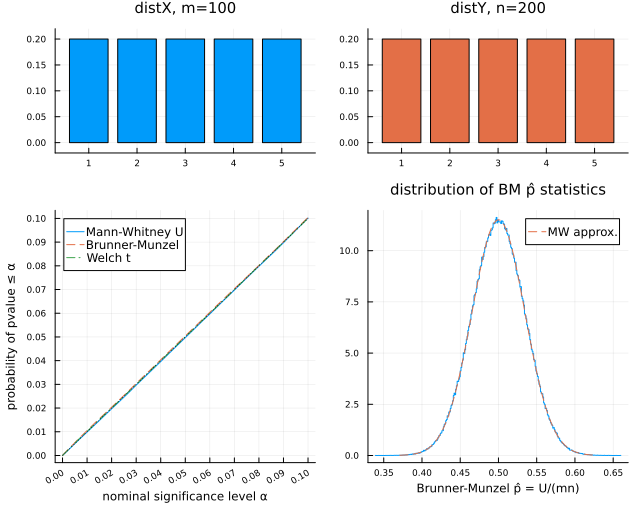

In [3]:
distX = DiscreteUniform(1, 5)
distY = DiscreteUniform(1, 5)
m, n = 100, 200
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.4, 0.25)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.6, 0.75)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.4, 0.25)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.2, 0.05)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (2.0, 0.8)
rd.((skewness(distX), skewness(distY))) = (0.0, -0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (-1.3, 0.125)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.092308, 0.026623)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050439, 0.010459)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.050071, 0.010228)


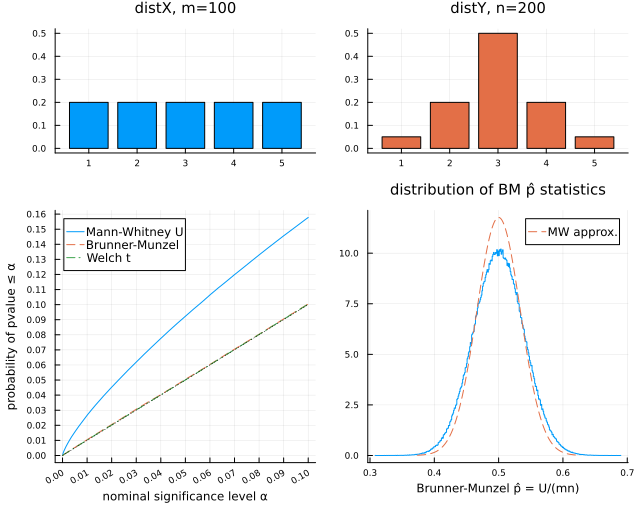

In [4]:
distX = DiscreteUniform(1, 5)
distY = Categorical(0.05, 0.2, 0.5, 0.2, 0.05)
m, n = 100, 200
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.4, 0.25)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.6, 0.75)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.4, 0.25)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.2, 0.05)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (2.0, 0.8)
rd.((skewness(distX), skewness(distY))) = (0.0, -0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (-1.3, 0.125)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.060623, 0.013489)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.05038, 0.010406)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.049837, 0.009951)


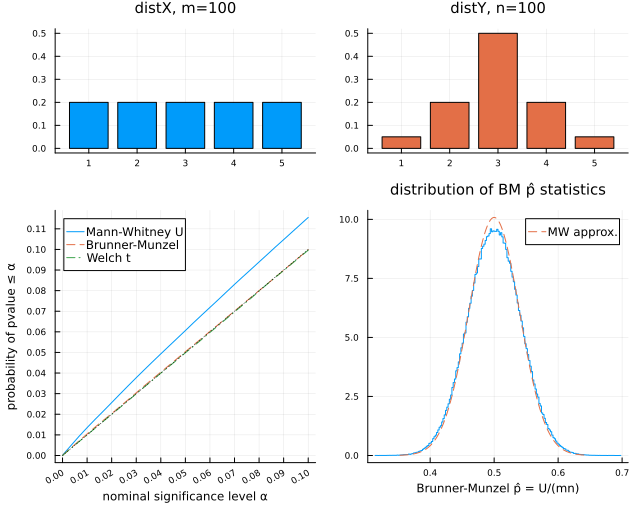

In [5]:
m, n = 100, 100
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.4, 0.25)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.6, 0.75)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.4, 0.25)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.2, 0.05)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (2.0, 0.8)
rd.((skewness(distX), skewness(distY))) = (0.0, -0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (-1.3, 0.125)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.033693, 0.005267)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050269, 0.010394)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.04977, 0.010027)


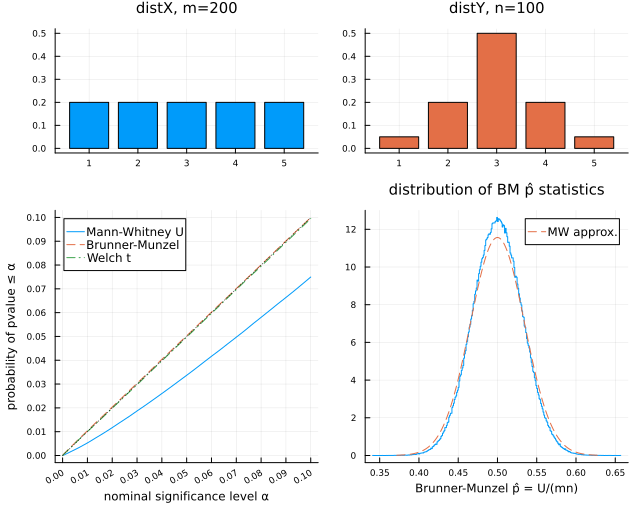

In [6]:
m, n = 200, 100
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.25, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.75, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.25, 0.125)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.083, 0.125)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (1.0, 1.0)
rd.((skewness(distX), skewness(distY))) = (0.0, 0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (0.0, 1.0)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.09182, 0.026448)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050408, 0.010479)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.049992, 0.0101)


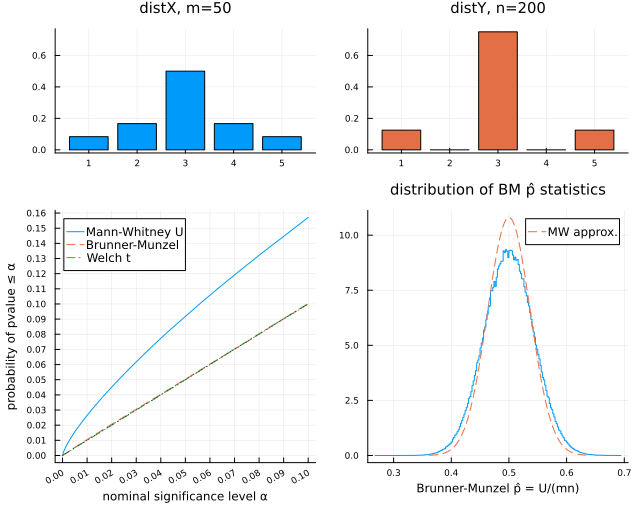

In [7]:
p = 1/12
distX = Categorical(p, 2p, 1-6p, 2p, p)
q = 3p/2
distY = Categorical(q, 0, 1-2q, 0, q)
m, n = 50, 200
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.25, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.75, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.25, 0.125)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.083, 0.125)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (1.0, 1.0)
rd.((skewness(distX), skewness(distY))) = (0.0, 0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (0.0, 1.0)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.054951, 0.011433)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050937, 0.010712)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.049914, 0.009926)


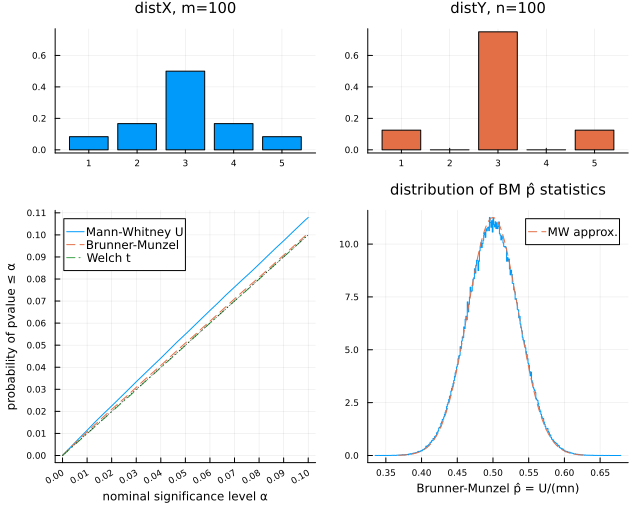

In [8]:
m, n = 100, 100
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.25, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.75, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.25, 0.125)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.083, 0.125)

rd.((median(distX), median(distY))) = (3.0, 3.0)
rd.((mean(distX), mean(distY))) = (3.0, 3.0)
rd.((var(distX), var(distY))) = (1.0, 1.0)
rd.((skewness(distX), skewness(distY))) = (0.0, 0.0)
rd.((kurtosis(distX), kurtosis(distY))) = (0.0, 1.0)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.031481, 0.004478)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.051365, 0.011075)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.049503, 0.009609)


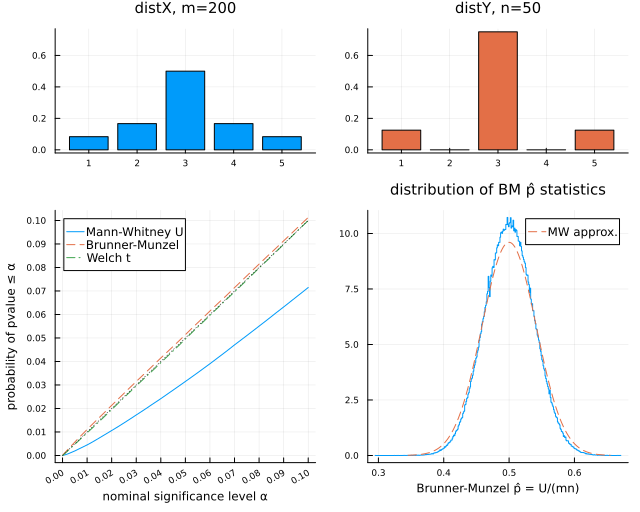

In [9]:
m, n = 200, 50
plot_MWU_BM_Welch(distX, distY, m, n; plot_Welch=true)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.083, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.917, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.75, 0.875)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.25, 0.153)

rd.((median(distX), median(distY))) = (4.0, 4.0)
rd.((mean(distX), mean(distY))) = (3.875, 3.84)
rd.((var(distX), var(distY))) = (0.943, 0.94)
rd.((skewness(distX), skewness(distY))) = (-1.114, -1.735)
rd.((kurtosis(distX), kurtosis(distY))) = (1.343, 2.731)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.092006, 0.026569)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050469, 0.010568)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.065141, 0.017942)


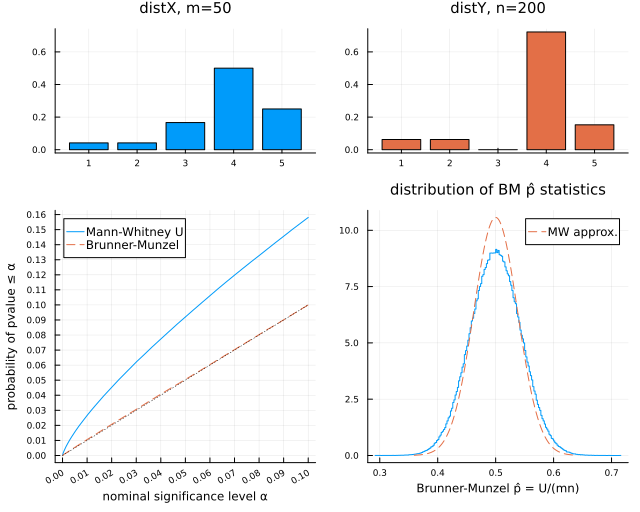

In [10]:
p = 1/12
distX = Categorical(p/2, p/2, 2p, 1-6p, 3p)
q = 3p/2
a = 0.5
b = 0.17460318
distY = Categorical((1-a)*q, a*q, 0, (1-b)*(1-q), b*(1-q))
m, n = 50, 200
plot_MWU_BM_Welch(distX, distY, m, n)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.083, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.917, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.75, 0.875)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.25, 0.153)

rd.((median(distX), median(distY))) = (4.0, 4.0)
rd.((mean(distX), mean(distY))) = (3.875, 3.84)
rd.((var(distX), var(distY))) = (0.943, 0.94)
rd.((skewness(distX), skewness(distY))) = (-1.114, -1.735)
rd.((kurtosis(distX), kurtosis(distY))) = (1.343, 2.731)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.054288, 0.011344)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.050916, 0.010865)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.055714, 0.01122)


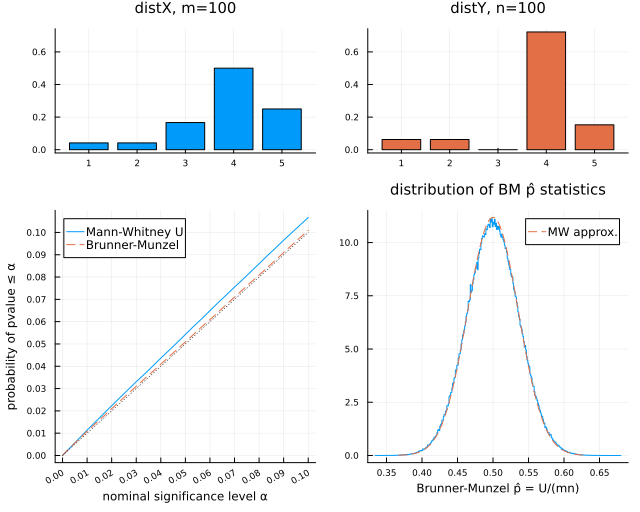

In [11]:
m, n = 100, 100
plot_MWU_BM_Welch(distX, distY, m, n)

rd.((cdf(distX, 2), cdf(distY, 2))) = (0.083, 0.125)
rd.((ccdf(distX, 2), ccdf(distY, 2))) = (0.917, 0.875)
rd.((ccdf(distX, 3), ccdf(distY, 3))) = (0.75, 0.875)
rd.((ccdf(distX, 4), ccdf(distY, 4))) = (0.25, 0.153)

rd.((median(distX), median(distY))) = (4.0, 4.0)
rd.((mean(distX), mean(distY))) = (3.875, 3.84)
rd.((var(distX), var(distY))) = (0.943, 0.94)
rd.((skewness(distX), skewness(distY))) = (-1.114, -1.735)
rd.((kurtosis(distX), kurtosis(distY))) = (1.343, 2.731)

rd.(bm_p_param(distX, distY)) = 0.5

(ecdf_pval_MWU(0.05), ecdf_pval_MWU(0.01)) = (0.028261, 0.003885)
(ecdf_pval_BM(0.05), ecdf_pval_BM(0.01)) = (0.051432, 0.011085)
(ecdf_pval_Welch(0.05), ecdf_pval_Welch(0.01)) = (0.051261, 0.011539)


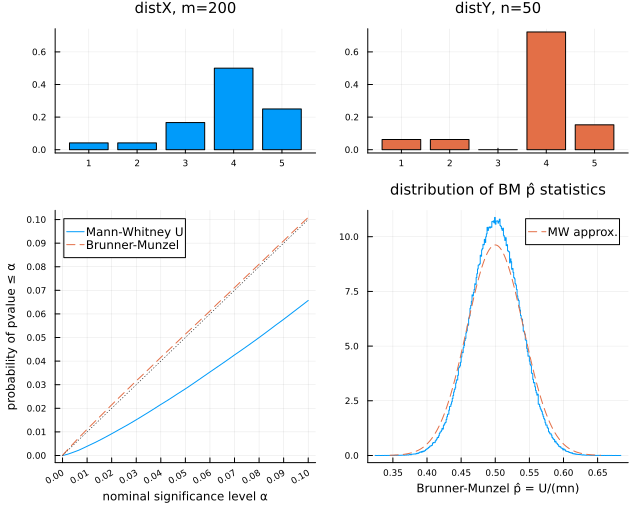

In [12]:
m, n = 200, 50
plot_MWU_BM_Welch(distX, distY, m, n)